# Explainable Machine Learning

In this project, we employ the concept of layer-wise relevance propagation to track back on which features DNNs base their decision. To this end, we follow the ideas put forward in "Layer-Wise Relevance Propagation: An Overview" by Grégoire Montavon et al., https://doi.org/10.1007/978-3-030-28954-6_10.

We apply the concept on the MNIST data set. For the sake of model simplicity, we consider a fully connected DNN and no convolutional neural networks, which are proven to perform better on image classification tasks. Here, we add noise to the data, to test if the ML solutions is capable of not putting importance in the background noise.

The main goal is to trace back, on which pixels and features neural networks base their decisions.
We aim to interprete what the relevant features the ML solution bases it's decision on and interprete this as "markers" for identifying numbers.

In [1]:
#Basic mathemtical operation
import numpy as np

#Neural network implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#Load Datasets
import torchvision
from torchvision import datasets, transforms

#For Visualization
import matplotlib.pyplot as plt

## Load MNIST and add noise 

In [2]:
# Define a function to add uniform noise to the image
class AddUniformNoise(object):
    def __init__(self, c):
        self.c = c

    def __call__(self, tensor):
        return tensor + torch.rand_like(tensor) * self.c


In [3]:
# Define a transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

# Define a transformation with the noise addition
c = 0.75# Adjust the value of c as needed
transformn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    AddUniformNoise(c) ])


# Load the training and test datasets
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transformn)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transformn)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)


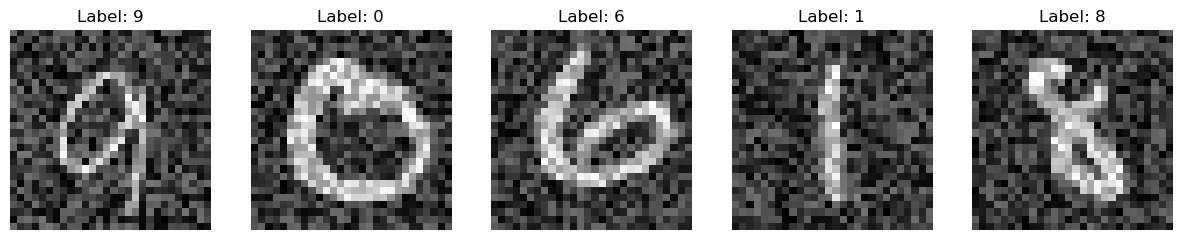

In [4]:
# Visualize a few images from the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display a few images from the dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx, ax in enumerate(axes):
    ax.imshow(images[idx].numpy().squeeze().reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {labels[idx]}')
    ax.axis('off')
plt.show()

In [5]:
print('The size of the data set is %d' %len(trainset))

The size of the data set is 60000


## Define the Neural Network

In [6]:
# Define the custom neural network
class CustomNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers):
        super(CustomNet, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_dim, hidden_dim)]
        
        # Hidden layers
        for i in range(num_hidden_layers):
            self.layers.append(nn.LeakyReLU(0.01))
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.layers.append(nn.LeakyReLU(0.01))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers.append(nn.LeakyReLU(0.01))
        
        # Assemble the layers into a sequential module
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.net(x)

In [7]:
# Define Neural network Parameters
input_dim = 28*28
hidden_dim = 250
output_dim = 10
num_hidden_layers = 7  # You can change this value to control the number of hidden layers

# Create an instance of the neural network
model = CustomNet(input_dim, hidden_dim, output_dim, num_hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train and evaluate the DNN

In [8]:
# Training the model
epochs = 25
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # Inside the training loop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    # Print the loss at each epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.5f}")

print("Training Finished")

# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Epoch 1/25, Loss: 6149.18403
Epoch 2/25, Loss: 2662.33854
Epoch 3/25, Loss: 2002.01859
Epoch 4/25, Loss: 1759.58115
Epoch 5/25, Loss: 1633.01387
Epoch 6/25, Loss: 1437.52157
Epoch 7/25, Loss: 1808.82723
Epoch 8/25, Loss: 1835.19617
Epoch 9/25, Loss: 1265.82069
Epoch 10/25, Loss: 1252.42249
Epoch 11/25, Loss: 1174.63164
Epoch 12/25, Loss: 1196.22472
Epoch 13/25, Loss: 1251.05454
Epoch 14/25, Loss: 1128.05961
Epoch 15/25, Loss: 1740.09213
Epoch 16/25, Loss: 1275.15515
Epoch 17/25, Loss: 22495.33351
Epoch 18/25, Loss: 959.87671
Epoch 19/25, Loss: 906.51959
Epoch 20/25, Loss: 950.15056
Epoch 21/25, Loss: 841.65453
Epoch 22/25, Loss: 830.37072
Epoch 23/25, Loss: 811.26739
Epoch 24/25, Loss: 792.42665
Epoch 25/25, Loss: 750.97198
Training Finished
Accuracy on the test set: 95.62%


In [9]:
# Evaluation on the test data
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
num_classes=output_dim

# Initialize dictionaries to keep track of correctly and incorrectly predicted counts for each class
correct_counts = {class_idx: 0 for class_idx in range(num_classes)}
incorrect_counts = {class_idx: 0 for class_idx in range(num_classes)}

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count the number of correctly and incorrectly predicted data points for each class
        for class_idx in range(num_classes):
            correct_counts[class_idx] += ((predicted == labels) & (labels == class_idx)).sum().item()
            incorrect_counts[class_idx] += ((predicted != labels) & (labels == class_idx)).sum().item()

test_loss /= len(testloader)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Size of test: {total}")
print("Class-wise Accuracies:")
for class_idx in range(num_classes):
    if incorrect_counts[class_idx]>0 or correct_counts[class_idx]>0 :
        print(f"Number {class_idx}:   ", f"Correct: {correct_counts[class_idx]}", f"False: {incorrect_counts[class_idx]}", f"Accuracy: {correct_counts[class_idx]/(correct_counts[class_idx]+incorrect_counts[class_idx])}",sep='\t')
        

Test Loss: 0.0000, Test Accuracy: 0.9578, Size of test: 10000
Class-wise Accuracies:
Number 0:   	Correct: 967	False: 13	Accuracy: 0.986734693877551
Number 1:   	Correct: 1115	False: 20	Accuracy: 0.9823788546255506
Number 2:   	Correct: 1018	False: 14	Accuracy: 0.9864341085271318
Number 3:   	Correct: 965	False: 45	Accuracy: 0.9554455445544554
Number 4:   	Correct: 958	False: 24	Accuracy: 0.9755600814663951
Number 5:   	Correct: 821	False: 71	Accuracy: 0.9204035874439462
Number 6:   	Correct: 939	False: 19	Accuracy: 0.9801670146137788
Number 7:   	Correct: 984	False: 44	Accuracy: 0.9571984435797666
Number 8:   	Correct: 869	False: 105	Accuracy: 0.8921971252566735
Number 9:   	Correct: 942	False: 67	Accuracy: 0.933597621407334


We find that the neural network performs sufficiently well, with a total accuracy of 95%. The different handrwirrten numbers differ in the quality of detectiction, ranging between 97% for the number "1" and 87% for the number "6".

## Visulalisation of the weight strcuture and node values of the network

The visualisation of the node values lays the basis for the layer-wise relevance propagation.

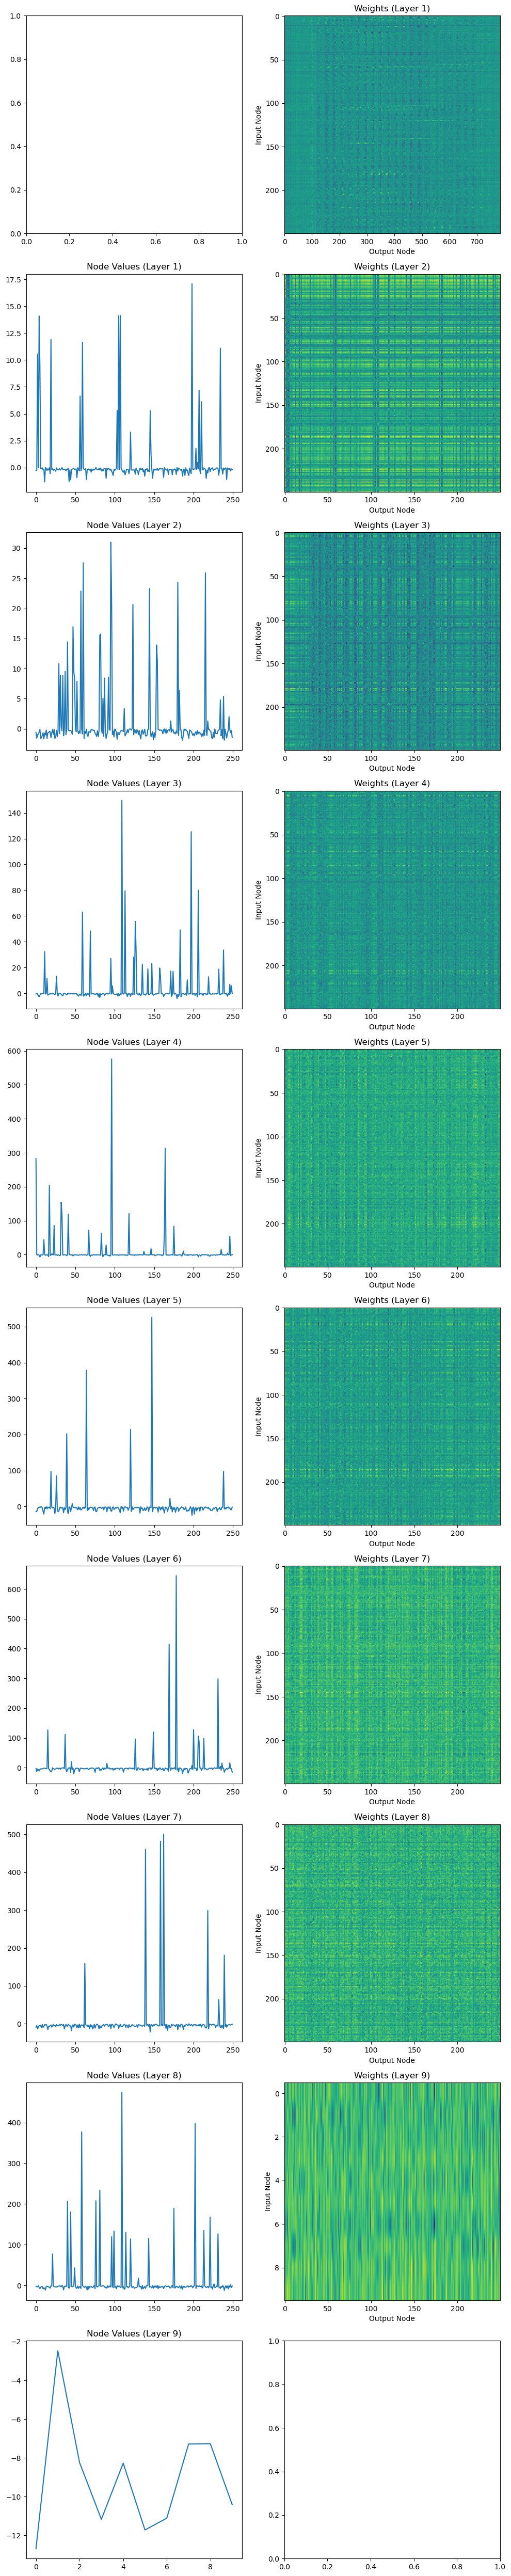

tensor([-12.6890,  -2.4700,  -8.2476, -11.1729,  -8.2730, -11.7223, -11.1123,
         -7.2853,  -7.2775, -10.4139], grad_fn=<LeakyReluBackward0>)
tensor([-12.6890,  -2.4700,  -8.2476, -11.1729,  -8.2730, -11.7223, -11.1123,
         -7.2853,  -7.2775, -10.4139])


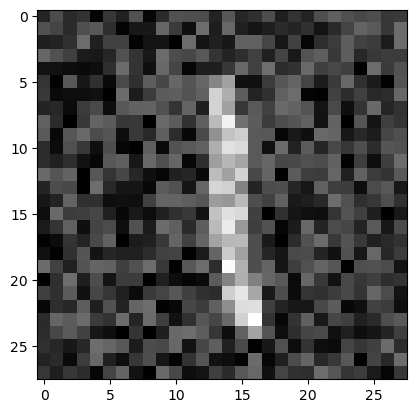

In [10]:

# Define a function to visualize weights and node values for a given input
def visualize_network(model, input_image):
    # Set the model in evaluation mode
    model.eval()

    # Get the forward pass of the input through the network
    with torch.no_grad():
        output = model(input_image)

    # Extract the weights and node values for each layer
    weights = []
    node_values = []
    node_values.append(input_image)  # The input image is the initial node value

    # Loop through each layer in the model to collect weights and node values
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.data)
            # Compute the output of the layer using the current node value
            output_of_layer = F.leaky_relu(layer(node_values[-1])  , negative_slope=0.01)              
            node_values.append(output_of_layer)

    # Plot the weights and node values
    fig, axs = plt.subplots(len(weights) + 1, 2, figsize=(10, 5 * (len(weights) + 1)))

    # Plot node values
    for i, node_value in enumerate(node_values[1:]):
        axs[i + 1, 0].plot(node_value.squeeze().detach().numpy())
        axs[i + 1, 0].set_title(f'Node Values (Layer {i + 1})')

    # Plot weights
    for i, weight in enumerate(weights):
        axs[i, 1].imshow(weight, cmap='viridis', aspect='auto')
        axs[i, 1].set_title(f'Weights (Layer {i + 1})')
        axs[i, 1].set_xlabel('Output Node')
        axs[i, 1].set_ylabel('Input Node')

    plt.tight_layout()
    plt.show()
    print(node_values[-1])
    print(output)

# Assuming 'model' is your trained network and 'input_image' is a sample image from the dataset
input_image, label = next(iter(testloader))
visualize_network(model, input_image[0].view(-1))  # Adjust the input shape if needed
plt.imshow(input_image[0].reshape(28, 28), cmap='gray')
plt.show()

Regarding the the node values:
We find that each layer is dominated by a few nodes of high values, while the majority of the nodes is seems to hardly contribute to the signal propagation thorugh the network.

Regarding the weight strucure:
We find that there is a distinct striped pattern both in vertical and horizontal direction. This indicates that some nodes accumulate high/small valued weights.

## Layer-wise Relevance Propagation

In [11]:
# Define a function to visualize weights and node values for a given input
def zjk(a, w, gam):
    return (a * (w + torch.maximum(w, torch.zeros_like(w)) * gam))**2

def relevance_prop(model, input_image):
    eps=0.01
    gam=0.0
    
    # Set the model in evaluation mode
    model.eval()

    # Get the forward pass of the input through the network
    with torch.no_grad():
        output = model(input_image)

    # Extract the weights and node values for each layer
    weights = []
    node_values = [input_image]  # The input image is the initial node value

    # Loop through each layer in the model to collect weights and node values
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.data)
            # Compute the output of the layer using the current node value
            output_of_layer = F.leaky_relu(layer(node_values[-1])  , negative_slope=0.01)              
            node_values.append(output_of_layer)

    
    #Iterate through the layer
    
    #Start with final layer
    #First apply a softmax operation.
    normalized_result = torch.nn.functional.softmax(node_values[-1], dim=0)
   
    #Save the relevance per layer
    relevance_col=[]
    relevancej=normalized_result
    relevance_col.append(relevancej)
    relevancejo=relevancej
    
    
    #Propagate the relevance
    for rep in range(len(weights)):
        #Get the size of the next layer and the previous layer.
        sizek = len(node_values[-(rep + 1)])
        sizej = len(node_values[-(rep + 2)])

        relevancej = np.zeros(sizej)
        relevance_col = []
        
        #Relevance propagatipn
        for cj in range(sizej):
            sumv = 0
            for ck in range(sizek):
                nominator = zjk(node_values[-(rep + 2)][cj], weights[-(rep + 1)][ck][cj], gam)
                denominator = (zjk(node_values[-(rep + 2)], weights[-(rep + 1)][ck], gam)).sum() + eps
                sumv += nominator / denominator * relevancejo[ck]

            relevancej[cj] = sumv

        relevance_col.append(relevancej)
        relevancejo = relevancej
        
    return relevance_col




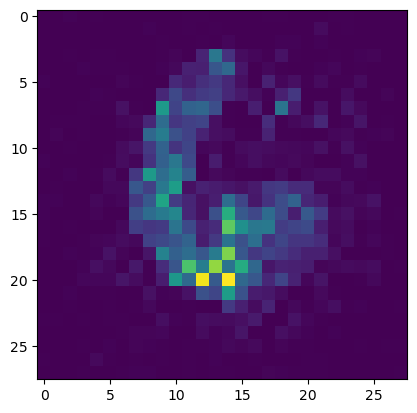

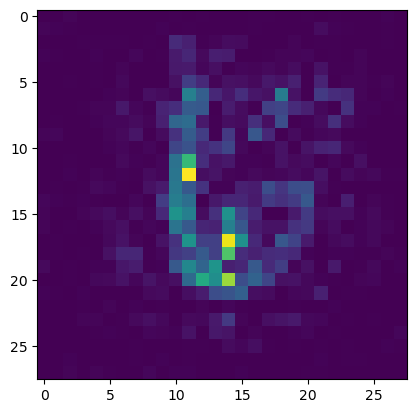

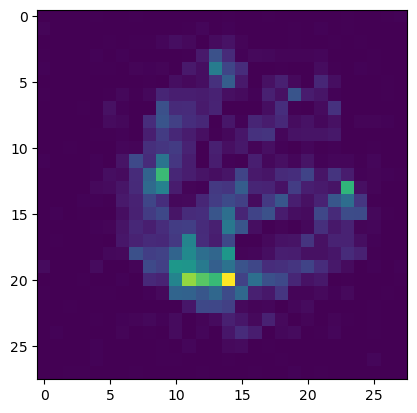

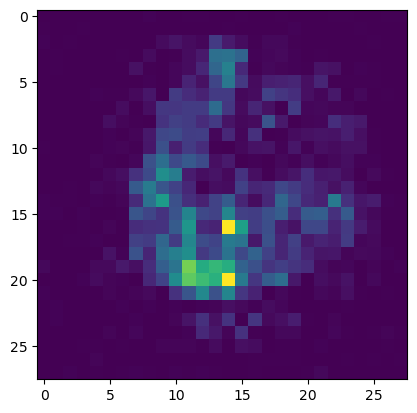

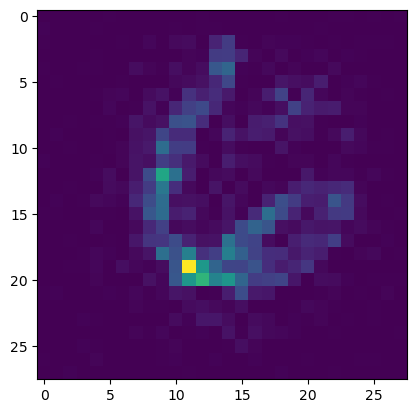

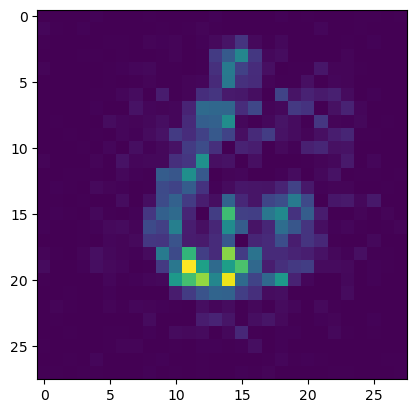

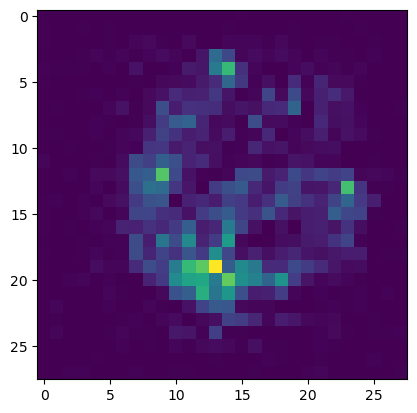

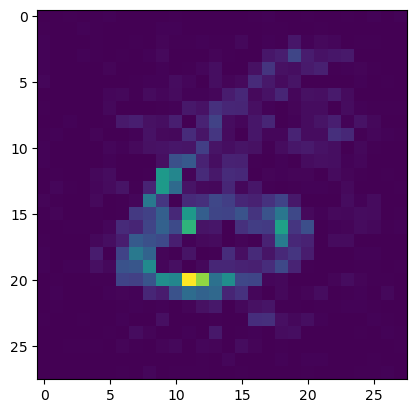

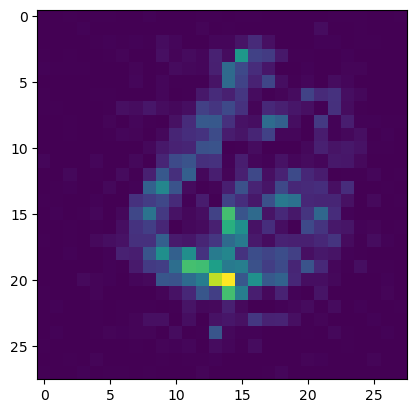

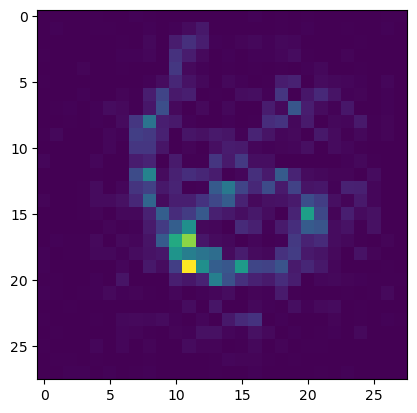

In [12]:
# Test for a number to learn about the features

#Iterate for the same numer
counted=10
counter=0

#Number to investigate
numti=6

#Iterate through test dataset
while(counter<counted):
    input_image, label = next(iter(testloader))
    if label[0]==numti:
        
        relevances=relevance_prop(model, input_image[0].view(-1))  # Adjust the input shape if needed
        plt.imshow(relevances[-1].reshape(28,28))
        plt.show()
        counter+=1

We find that the DNN is capable to put relevance on the center of the image and to filter out noise in the image effectively.

Specifically for the number six, we find that bigger relevance is put on the 3-fold junction where the circle and the "tail" merge. Furthermore, also the the "tail" itself received increased relevanced. In contrast to this, the circle of the 6 obtained reduced variance only. This indicates that the circle is a common structure of handwritten numbers, while the "special" features of the 6 include the 3-fold junction and the rather straight tail. 

## Relevance backpropagation for alternative labels

We next test, how a "faulty" classification would propagate back. In particular, we find that "6" and "5" are structure-wise similar features, where the for "5" the circle has a hole.

In [13]:
# Define a function to visualize weights and node values for a given input
def zjk(a, w, gam):
    return (a * (w + torch.maximum(w, torch.zeros_like(w)) * gam))**2

# Relevance propagation with externally controlled output relevance
def relevance_prop_num(model, input_image,num):
    eps=0.01
    gam=0.01
    
    # Set the model in evaluation mode
    model.eval()

    # Get the forward pass of the input through the network
    with torch.no_grad():
        output = model(input_image)

    # Extract the weights and node values for each layer
    weights = []
    node_values = [input_image]  # The input image is the initial node value

    # Loop through each layer in the model to collect weights and node values
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.data)
            # Compute the output of the layer using the current node value
            output_of_layer = F.leaky_relu(layer(node_values[-1])  , negative_slope=0.01)              
            node_values.append(output_of_layer)

    #print(weights[-1])
    
    #Iterate through the layer
    
    # Create a tensor of zeros
    normalized_result = torch.zeros(10)

    # Set the value at the specified position to 1
    normalized_result[num] = 1
    print(normalized_result)
    
    #Save the relevance per layer
    relevance_col=[]
    relevancej=normalized_result
    relevance_col.append(relevancej)
    relevancejo=relevancej
    
    
    #Propagate the relevance
    for rep in range(len(weights)):
        #Get the size of the next layer and the previous layer.
        sizek = len(node_values[-(rep + 1)])
        sizej = len(node_values[-(rep + 2)])

        relevancej = np.zeros(sizej)
        relevance_col = []
        
        #Relevance propagatipn
        for cj in range(sizej):
            sumv = 0
            for ck in range(sizek):
                nominator = zjk(node_values[-(rep + 2)][cj], weights[-(rep + 1)][ck][cj], gam)
                denominator = (zjk(node_values[-(rep + 2)], weights[-(rep + 1)][ck], gam)).sum() + eps
                sumv += nominator / denominator * relevancejo[ck]

            relevancej[cj] = sumv

        relevance_col.append(relevancej)
        relevancejo = relevancej
        
    return relevance_col




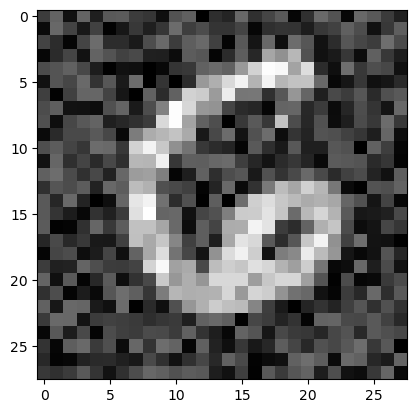

In [33]:
#Get correct number
isnum=False
while(isnum==False):
    input_image, label = next(iter(testloader))
    if label[0]==6:
        isnum=True
        

#Plot original image 
plt.imshow(input_image[0].reshape(28, 28), cmap='gray')
plt.show()

In [34]:
plt.set_cmap('bwr') #Set diverging colormap for better inspection

col_relevances=[]
#Relevance propagation
for counter in [5,6]:
    print(counter)
    relevances=relevance_prop_num(model, input_image[0].view(-1),counter)  # Adjust the input shape if needed
    col_relevances.append(relevances[-1].reshape(28,28))

5
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
6
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


<Figure size 640x480 with 0 Axes>

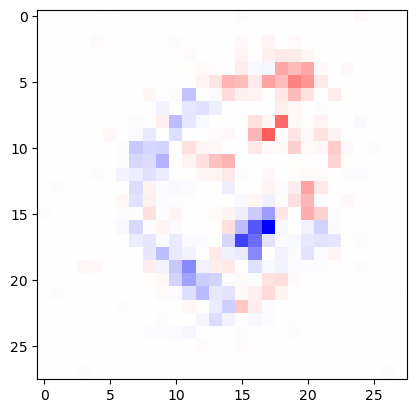

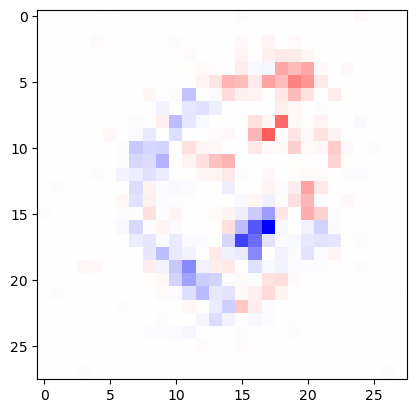

In [35]:
#Show differences

#Get values for image normalisation
max_valo=np.sum(np.abs(col_relevances[1]))
max_valelem=np.sum(np.abs(col_relevances[0]))

difim=col_relevances[1]/max_valo-col_relevances[0]/max_valelem
max_val = np.max(np.abs(difim))  # Compute the maximum absolute value for image color limits

#Plot differences
plt.imshow(difim,vmin=-max_val, vmax=max_val)
plt.show()

#Plot differences
plt.imshow(difim,vmin=-max_val, vmax=max_val)
plt.show()



We find that the 3-fold junction has stronger relevance for the "6". 
When fed with the "5", incrased importance was put on the noise, direclty above the circle. A "5" was interpreted into the data.